<a href="https://colab.research.google.com/github/adrian-valente/XAI_course_labs/blob/main/lab1_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

# Part 1: regression (bike data)

In [ ]:
# Download bike dataset
!wget http://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
!unzip bike+sharing+dataset.zip

--2023-11-05 19:06:01--  http://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bike+sharing+dataset.zip’

bike+sharing+datase     [   <=>              ] 273.43K   347KB/s    in 0.8s    

2023-11-05 19:06:02 (347 KB/s) - ‘bike+sharing+dataset.zip’ saved [279992]

Archive:  bike+sharing+dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


## Load and preprocess data

In [ ]:
df = pd.read_csv('day.csv')

In [ ]:
df['temp'] = df['temp'] * 47 - 8
df['atemp'] = df['atemp'] * 66 - 16
df['windspeed'] = df['windspeed'] * 67
df['weatherCloudy'] = (df['weathersit'] == 2).astype(int)
df['weatherRainy'] = (df['weathersit'] == 3).astype(int)
df['weatherStorm'] = (df['weathersit'] == 4).astype(int)
df['seasonSpring'] = (df['season'] == 2).astype(int)
df['seasonSummer'] = (df['season'] == 3).astype(int)
df['seasonFall'] = (df['season'] == 4).astype(int)

dates = df['dteday']
df = df.drop(columns=['yr', 'weekday', 'instant', 'season', 'mnth', 'casual', 'registered', 'weathersit', 'dteday'])

In [ ]:
df.describe()
df = df.drop(columns=['weatherStorm'])

In [ ]:
df.head(10)

,holiday,workingday,temp,atemp,hum,windspeed,cnt,weatherCloudy,weatherRainy,seasonSpring,seasonSummer,seasonFall
0,0,0,8.175849,7.999250,0.805833,10.749882,985,1,0,0,0,0
1,0,0,9.083466,7.346774,0.696087,16.652113,801,1,0,0,0,0
2,0,1,1.229108,-3.499270,0.437273,16.636703,1349,0,0,0,0,0
3,0,1,1.400000,-1.999948,0.590435,10.739832,1562,0,0,0,0,0
4,0,1,2.666979,-0.868180,0.436957,12.522300,1600,0,0,0,0,0
5,0,1,1.604356,-0.608206,0.518261,6.000868,1606,0,0,0,0,0
6,0,1,1.236534,-2.216626,0.498696,11.304642,1510,1,0,0,0,0
7,0,0,-0.245000,-5.291236,0.535833,17.875868,959,1,0,0,0,0
8,0,0,-1.498349,-8.332450,0.434167,24.250650,822,0,0,0,0,0
9,0,1,-0.910849,-6.041392,0.482917,14.958889,1321,0,0,0,0,0


## Train and evaluate a first model

In [ ]:
# Perform train-test split
X, y = df.drop(columns=['cnt']), df['cnt']
X_train, X_test = X.iloc[:500], X.iloc[500:]
y_train, y_test = y[:500], y[500:]

In [ ]:
# TODO: fit a linear regression, and evaluate it


R2 score on test set: -0.87 (on train set: 0.57)


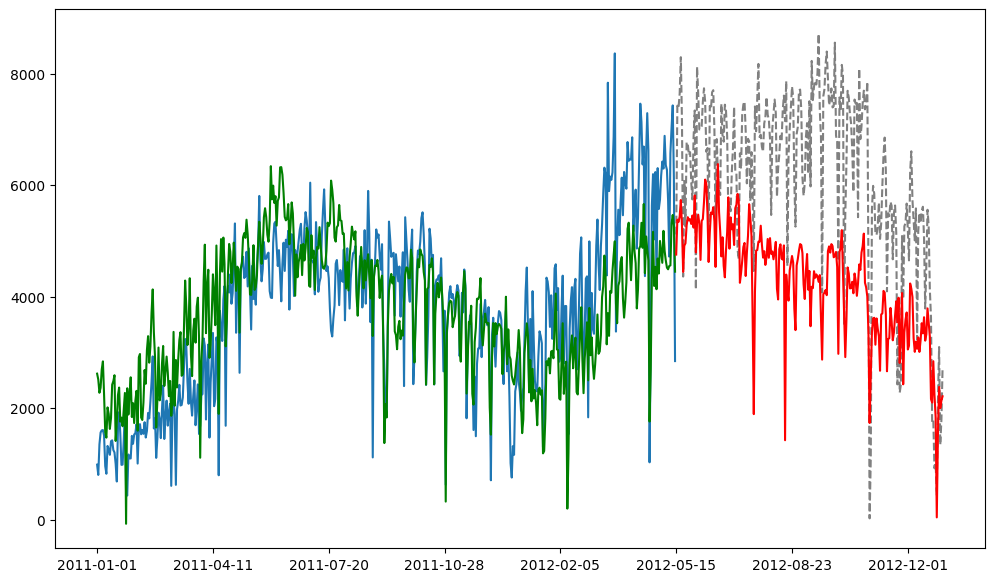

In [ ]:
# Visualizing the performance of the model
def plot_predictions(model):
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  plt.subplots(figsize=(12, 7))
  plt.plot(dates[:500], y[:500])
  plt.plot(dates[500:], y[500:], c='gray', ls='--')
  plt.plot(dates[:500], y_pred_train, c='green')
  plt.plot(dates[500:], y_pred_test, c='red')
  plt.xticks(dates[::100])
  plt.show()

plot_predictions(model1)

## Improve model

In [2]:
# TODO: Bring modifications to improve performance


## Model with confidence intervals

In [ ]:
# Helper class to wrap a scikit-learn API around statsmodels models

class SMWrapper:

  def __init__(self, sm_model_class, add_intercept=True, classification=False):
    self.sm_model_class = sm_model_class
    self.model = None
    self.add_intercept = add_intercept
    self.classification = classification

  def handle_intercept(self, X):
    if self.add_intercept:
      if isinstance(X, pd.DataFrame):
        _X = X.copy()
        _X['intercept'] = np.ones(X.shape[0])
      else:
        _X = np.hstack(X, np.ones(X.shape[0]))
    else:
      _X = X
    return _X

  def fit(self, X, y):
    _X = self.handle_intercept(X)
    self.model = self.sm_model_class(y, _X)
    self.results = self.model.fit()
    return self.results

  def predict(self, X):
    _X = self.handle_intercept(X)
    preds = self.model.predict(self.results.params, _X)
    if self.classification:
      if len(preds.shape) == 1:
        preds = (preds > 0.5).astype(int)
      else:
        preds = np.argmax(preds, axis=1)
    return preds


In [ ]:
# Fit linear regression

model = SMWrapper(sm.OLS)
result = model.fit(X_train, y_train)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     155.0
Date:                Sun, 05 Nov 2023   Prob (F-statistic):          1.16e-157
Time:                        19:25:47   Log-Likelihood:                -3985.3
No. Observations:                 500   AIC:                             7997.
Df Residuals:                     487   BIC:                             8051.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
holiday        -539.5984    200.499     -2.691      0.007    -933.547    -145.649
workingday       56.9086     70.873      0.803      0.422     -82.346     196.164
temp             97.8270     49.715      1.968      0.050       0.146     195.508
atemp             2.9340     38.919      0.075      0.940     -73.536      79.404
hum           -1422.9554    291.925     -4.874      0.000   -1996.543    -849.368
windspeed       -38.6177      6.875     -5.617      0.000     -52.127     -25.109
weatherCloudy  -291.5573     84.367     -3.456      0.001    -457.325    -125.790
weatherRainy  -1649.8708    202.108     -8.163      0.000   -2046.982   -1252.760
seasonSpring    805.4165    104.176      7.731      0.000     600.726    1010.107
seasonSummer    -33.5398    155.200     -0.216      0.829    -338.485     271.405
seasonFall      161.0379    105.149      1.532      0.126     -45.563     367.639
trend             5.2721      0.229     23.028      0.000       4.822       5.722
intercept      2308.0782    264.554      8.724      0.000    1788.271    2827.886
==============================================================================
Omnibus:                       45.240   Durbin-Watson:                   1.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.192
Skew:                          -0.433   Prob(JB):                     2.93e-27
Kurtosis:                       5.261   Cond. No.                     3.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [3]:
# Evaluate


In [4]:
result.params

In [5]:
result.conf_int()

In [ ]:
# TODO: function to visualize parameters with uncertainty

def weight_plot(model, labels=None):
  pass


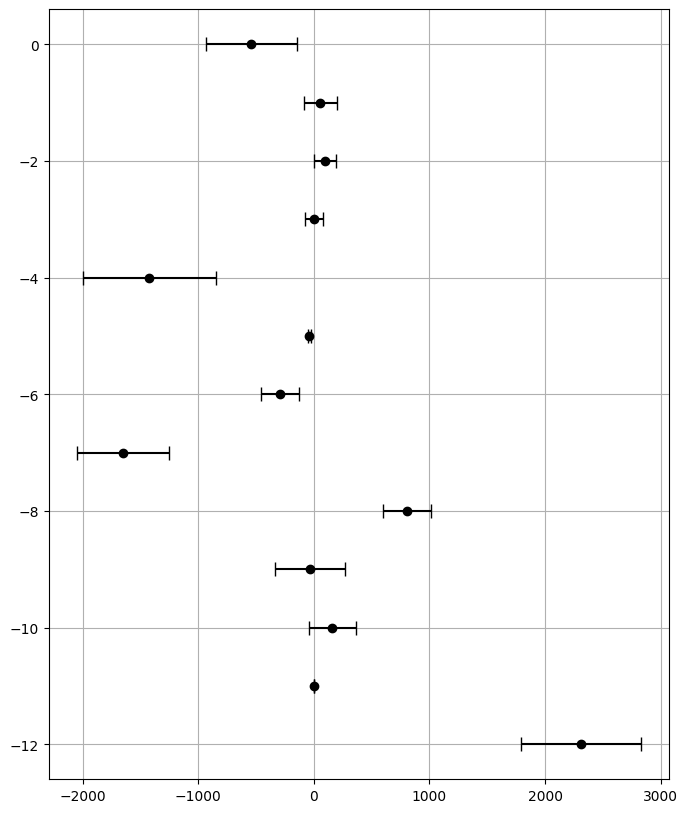

In [ ]:
weight_plot(model)

## Model on normalized data

TODO: redo the above analysis, with normalized data this time.

In [ ]:
# Refit on normalized data
X, y = df.drop(columns=['cnt']), df['cnt']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(data=X_scaled, columns=X.columns)
X_train, X_test = X_scaled[:500], X_scaled[500:]
y_train, y_test = y[:500], y[500:]

In [6]:
model = SMWrapper(sm.OLS)
result = model.fit(X_train, y_train)
result.summary()

In [7]:
# Evaluate

## Effects analysis

In [ ]:
# Back to non-normalized model
X_train, X_test = X.iloc[:500], X.iloc[500:]
y_train, y_test = y[:500], y[500:]

In [ ]:
# TODO: complete

def compute_effects(model, X, normalize=False):
  if isinstance(model, SMWrapper):
    if model.add_intercept:
      params = np.array(model.results.params)[:-1]
      intercept = np.array(model.results.params)[-1]
    else:
      params = np.array(model.results.params)
      intercept = 0
  elif isinstance(model, sklearn.base.BaseEstimator):
    params = model.coef_
    intercept = model.intercept_

  # FILL HERE: complete code to compute effects
  # ...

  if normalize:
    preds = model.predict(X)
    effects = (effects.T / (preds - intercept)).T

  return effects

In [ ]:
def plot_effects(effects):
  fig, ax = plt.subplots(figsize=(8, 10))
  sns.boxplot(effects, orient='h', ax=ax)

## Bonus:

1) Explain the predictions for the downward peaks observed in the test set (and correctly identified by the model). Can you justify why the model predicts low rentals these days?

2) Can you explain why some of the top peaks in the test data are not identified by the model? What is the rationale in the predictions these days?

3) Can you prune some of the input variables out of your model? If yes, which ones, and can you train a model without them and check its performance?

4) Try to train more complex models. Does the performance increase? Can you explain their predictions?

5) In the linear regression case, think about some business logic for an applications that gives predictions with explanations, and how it interfaces with your model.

# Part 2: classification (breast cancer data)

In [ ]:
# Load data
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = pd.DataFrame(data=data.data, columns=data.feature_names)
y = data.target

In [ ]:
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [ ]:
# Preprocessing (these columns almost collinear)
X = X.drop(columns=['worst perimeter', 'worst area', 'mean perimeter', 'mean area'])

## Logistic regression

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
# TODO: train a logistic regression model and evaluate it

## Obtaining confidence intervals with bootstrapping

In [ ]:
# TODO: train 10 models with bootstrapping (p=0.7) and visualize the
# distribution of obtained weights
boot_p = 0.7
boot_n = int(boot_p * X_train.shape[0])

models = []
for _ in range(10):
  # FILL HERE
  pass

In [ ]:
def plot_all_weights(models, labels=None):
  fig, ax = plt.subplots(figsize=(8, 10))
  params = np.zeros((len(models), models[0].coef_.shape[1] + 1))
  for i, mod in enumerate(models):
    params[i] = np.append(mod.coef_, mod.intercept_)
  params_data = pd.DataFrame(data=params, columns=labels)
  sns.boxplot(params_data, orient='h')
  plt.show()

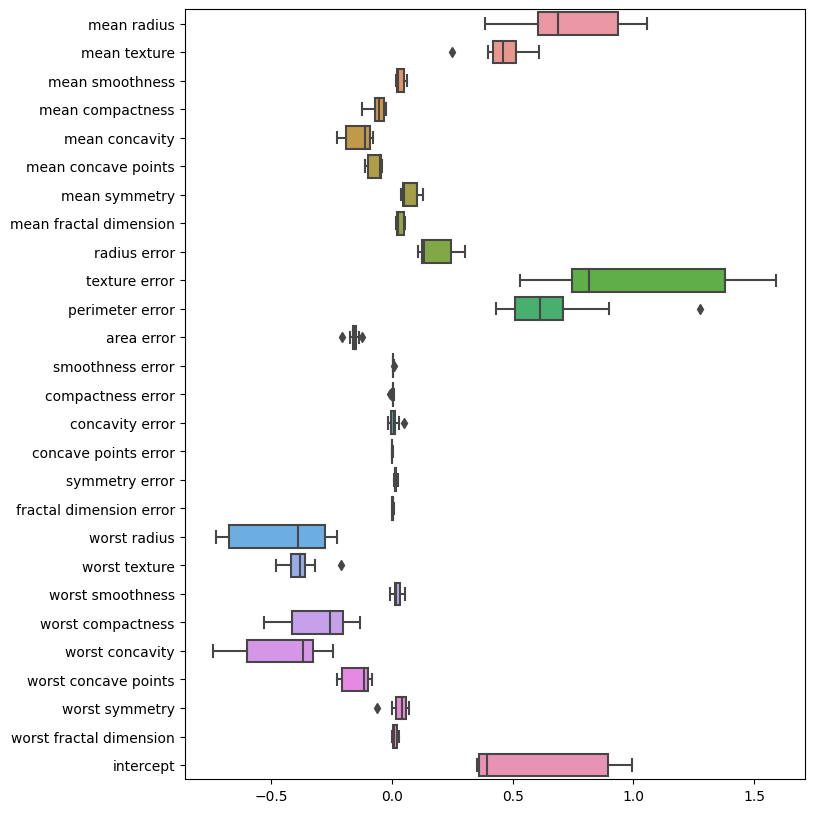

In [ ]:
plot_all_weights(models, labels=X_train.columns.tolist() + ['intercept'])

## Visualization of effects

TODO: perform visualization of effects

## Now with normalization

Perform the same analysis on a model trained on normalized data.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Lasso model

In [11]:
# TODO: train a logistic regression LASSO model (with L1 penalty) and analyse it


## Going further

1) Pick up a few examples recognized as malignant cases and explain the algorithms's decision. How would you explain the diagnostic to a patient?

2) Try to get a classifier using as few features as possible while keeping a similar performance. The original paper did it with 3 features only (in 1992): https://minds.wisconsin.edu/bitstream/handle/1793/59692/TR1131.pdf?sequence=1

3) Compare the use of L2 and L1 regularization on the interpretation of obtained classifiers.